In [16]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random


In [17]:
# Load tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [25]:
# Example list of news articles
df = pd.read_csv("dataset7.csv", on_bad_lines='skip')
df

,link,title,health_annotation,content,cluster,x,y,annotation
0,https://foodbabe.com/my-visit-to-the-white-hou...,My Visit To The White House – Exposing Big Foo...,1,"Someone needs to pinch me, because I almost ca...",5,0.031964,-0.180670,0
1,https://foodbabe.com/wk-kelloggs-ceo-gary-piln...,WK Kellogg’s CEO Gary Pilnick breaks his silen...,1,WK Kellogg’s CEO Gary Pilnick finally breaks h...,0,-0.025548,-0.116120,0
2,https://foodbabe.com/general-mills-has-been-pu...,General Mills has been put on notice: Remove d...,1,Our movement is growing bigger and faster than...,0,0.068932,0.001133,0
3,https://foodbabe.com/food-policy-expert-asks-k...,Food Policy Expert asks Kellogg’s CEO: “Would ...,1,"When I saw the New York Post headline, “Ex-FDA...",0,0.026184,-0.133570,0
4,https://foodbabe.com/w-k-kelloggs-cereal-heire...,W.K. Kellogg’s Cereal Heiress Exposes Kellogg’...,1,"Ever since we delivered 400,000 signed petitio...",0,-0.009792,-0.082135,0
...,...,...,...,...,...,...,...,...
6777,https://www.eaglenews.ph/infographics-national...,In China,1,"(Eagle News) — In the Philippines, cancer rema...",3,0.235913,0.046816,1
6778,https://www.eaglenews.ph/dr-congo-ebola-death-...,unhappiness tracks poor air quality,1,"KINSHASA, DR Congo (AFP) — The death toll from...",9,0.155704,-0.329712,1
6779,https://www.eaglenews.ph/s-africas-neighbours-...,Swine flu kills 40 in western India,1,"JOHANNESBURG, South Africa (AFP) — Countries n...",9,0.046792,-0.216438,1
6780,https://www.eaglenews.ph/hong-kong-scientists-...,INFOGRAPHICS: National Cancer Consciousness Week,1,"HONG KONG, China (AFP) — Hong Kong scientists ...",9,0.216361,-0.238194,1


In [26]:
df = df.dropna(subset=['content']).reset_index(drop=True)  # Critical: reset_index
texts = df['content'].tolist()  # Now texts and df have identical length
print(len(texts))

6782


In [20]:
# Encode df to embeddings
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # CLS token

In [31]:
embeddings = np.array([get_cls_embedding(text) for text in texts])

In [32]:
# embeddings
print(len(embeddings))

6782


In [33]:
# Cluster
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Map results
# for text, label in zip(df, clusters):
#     print(f"[Cluster {label}] {text}")


In [23]:
# kmeans = KMeans(n_clusters=10, random_state=42)
# kmeans.fit(embeddings)
# df['cluster'] = kmeans.labels_  # Works now!

Cluster sizes:
Cluster 0: 2115 articles
Cluster 1: 1360 articles
Cluster 2: 1422 articles
Cluster 3: 963 articles
Cluster 4: 922 articles


C:\Users\agaro\AppData\Local\Temp\ipykernel_18096\1544332840.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=cluster_labels, y=[0]*len(cluster_labels), jitter=0.25, palette="deep")


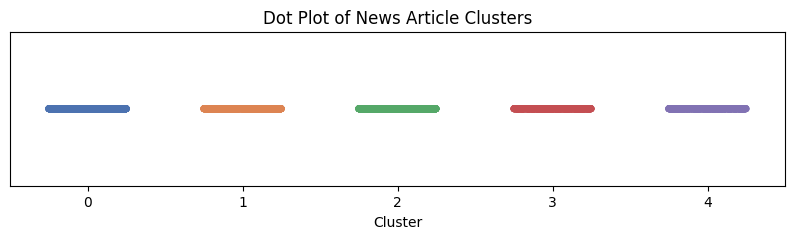


🔹 Cluster 0 examples:
• Someone needs to pinch me, because I almost can’t believe this is happening… I was invited to speak ...
• WK Kellogg’s CEO Gary Pilnick finally breaks his silence since we delivered over 400,000 petitions t...
• When I saw the New York Post headline, “Ex-FDA food expert reveals worst cereal in America with link...

🔹 Cluster 1 examples:
• If you drink Diet or Zero Calorie drinks, you’ve got to hear this. The International Agency for Rese...
• We all know that alcoholic drinks are not a health food – and alcohol itself is linked to cancer. Bu...
• Advertisement Consumer Reports (CR) has unveiled alarming findings indicating that one out of every ...

🔹 Cluster 2 examples:
• Advertisement In a study published in Pathology Oncology Research, academic pathologist Dr. Yujiang ...
• Advertisement With societal pressures and beauty standards that often dictate self-worth, more women...
• Advertisement Heart disease remains the leading cause of death worldwide, but eme

In [34]:
# Count articles in each cluster
from collections import Counter
cluster_counts = Counter(cluster_labels)

# Print cluster sizes
print("Cluster sizes:")
for cluster_id, count in sorted(cluster_counts.items()):
    print(f"Cluster {cluster_id}: {count} articles")

# 📊 Dot plot (strip style)
plt.figure(figsize=(10, 2))
sns.stripplot(x=cluster_labels, y=[0]*len(cluster_labels), jitter=0.25, palette="deep")
plt.xlabel("Cluster")
plt.title("Dot Plot of News Article Clusters")
plt.yticks([])
plt.show()

# 📌 Get example articles from each cluster
samples_per_cluster = 3
cluster_examples = {i: [] for i in range(5)}

for i, (text, label) in enumerate(zip(texts, cluster_labels)):
    if len(cluster_examples[label]) < samples_per_cluster:
        cluster_examples[label].append(text)

# Display samples
for cluster_id, examples in cluster_examples.items():
    print(f"\n🔹 Cluster {cluster_id} examples:")
    for example in examples:
        print(f"• {example[:100]}...")  # Print first 100 chars